In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

In [32]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [33]:
main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()
#y_true=df.iloc[y_test.index][clear_labels]

In [34]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [35]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

#X_tmp=np.zeros((np.shape(X_test.to_numpy())[0],np.shape(X_test.to_numpy())[1],9))
#for i in range(np.shape(X_tmp)[2]):
#    X_tmp[:,:,i]=X_test.to_numpy()

#pred_y=X_tmp-pred_y #For cloud estimation

In [36]:
tmp=models[0]
loss=tmp.train_loss.data.cpu().numpy()
np.argmin(loss[loss>0])

639

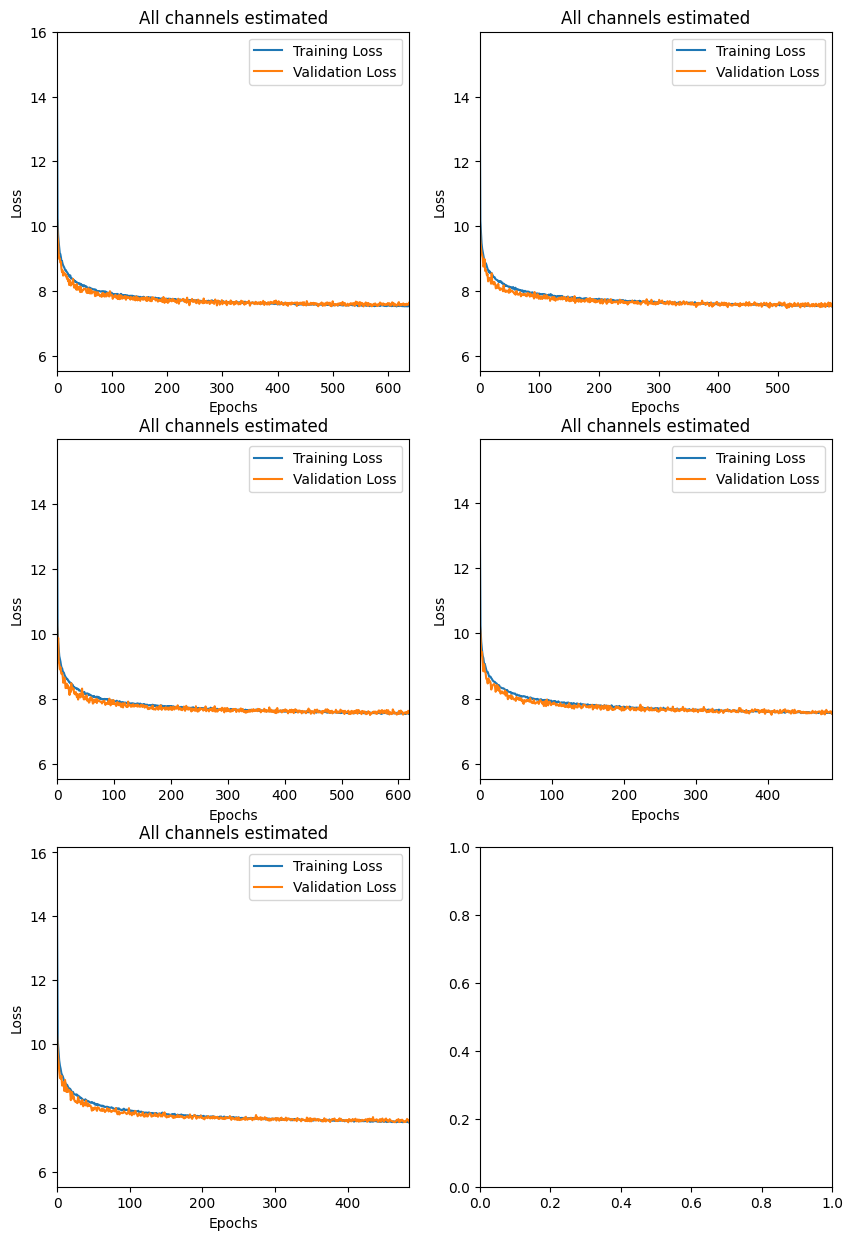

In [37]:
nmodels=len(models)
ncols=2
nrows=int(np.ceil(nmodels/ncols))
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i<nmodels:
        train_loss=models[i].train_loss.data.cpu().numpy()
        train_loss_l0=train_loss[train_loss>0]
        val_loss=models[i].val_loss.data.cpu().numpy()
        val_loss_l0=val_loss[val_loss>0]
        ax.plot(train_loss)
        ax.plot(val_loss)
        ax.set_title("All channels estimated")
        ax.legend(['Training Loss','Validation Loss'])
        ax.set_xlim(0,np.max([np.argmin(train_loss_l0),np.argmin(val_loss_l0)]))
        ax.set_ylim(np.min(train_loss_l0)-2,np.max(train_loss_l0)+2)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")

In [38]:
np.shape(pred_y)

(20000, 12, 9)

In [39]:
np.shape(y_test)

(20000, 12)

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics_one.py:194: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[f_i].errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,index_median]),len(y_pred_sort_samp[i][:,index_median]))


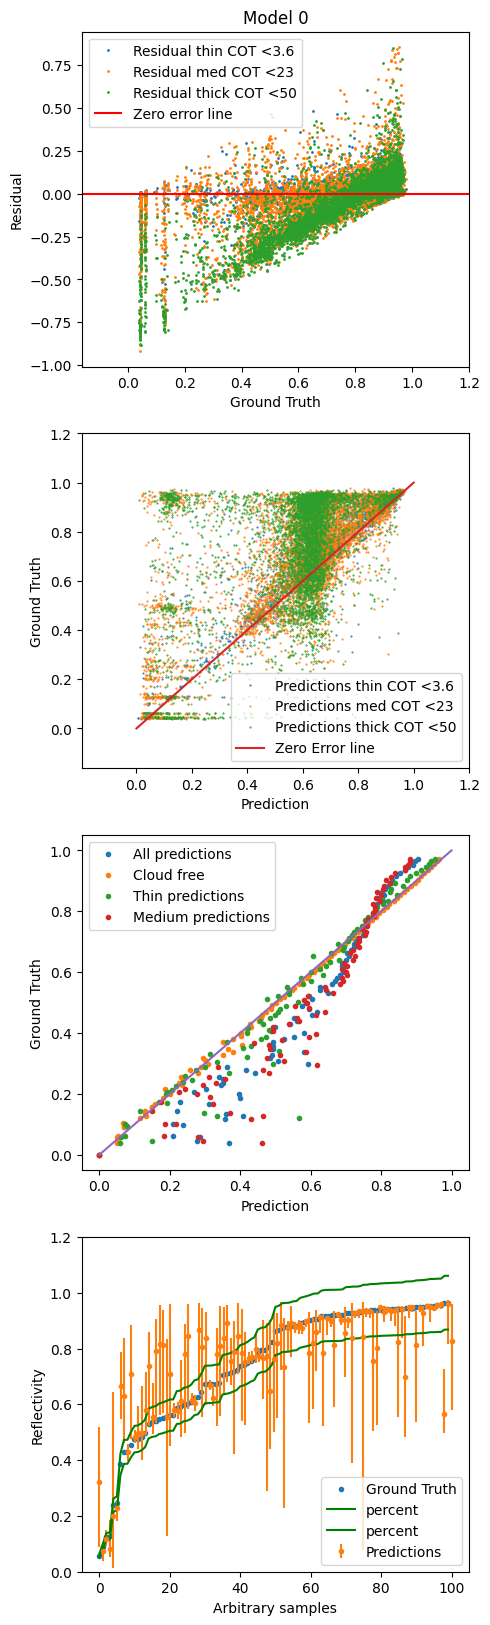

In [40]:
plt.rcParams["figure.figsize"] = [5, 5*4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics_one([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                is_ensemble=True,
                                                                index_median=4)

In [41]:
#Indices for different COT
cot_thin=3.6
cot_med=23
cot_thick=50

#Get indexes for optical thin, med and thick
test_indices=X_test.index
df_tmp=df.iloc[test_indices]

#Reset index for future indexing
df_tmp=df_tmp.reset_index()
df_tmp=df_tmp.drop(columns=["index"])

indices_zero=df_tmp[df_tmp['COT']==0].index
indices_thin=df_tmp[(df_tmp['COT']<=cot_thin)&df_tmp['COT']>0].index
indices_med=df_tmp[(df_tmp['COT']>cot_thin)&(df_tmp['COT']<=cot_med)].index
indices_thick=df_tmp[df_tmp['COT']>cot_med].index

/tmp/ipykernel_230180/468801031.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_230180/468801031.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_230180/468801031.py:74: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_230180/468801031.py:96: UserWarning: marker is re

Text(0.5, 1.0, '23 < COT < 50 (thick)')

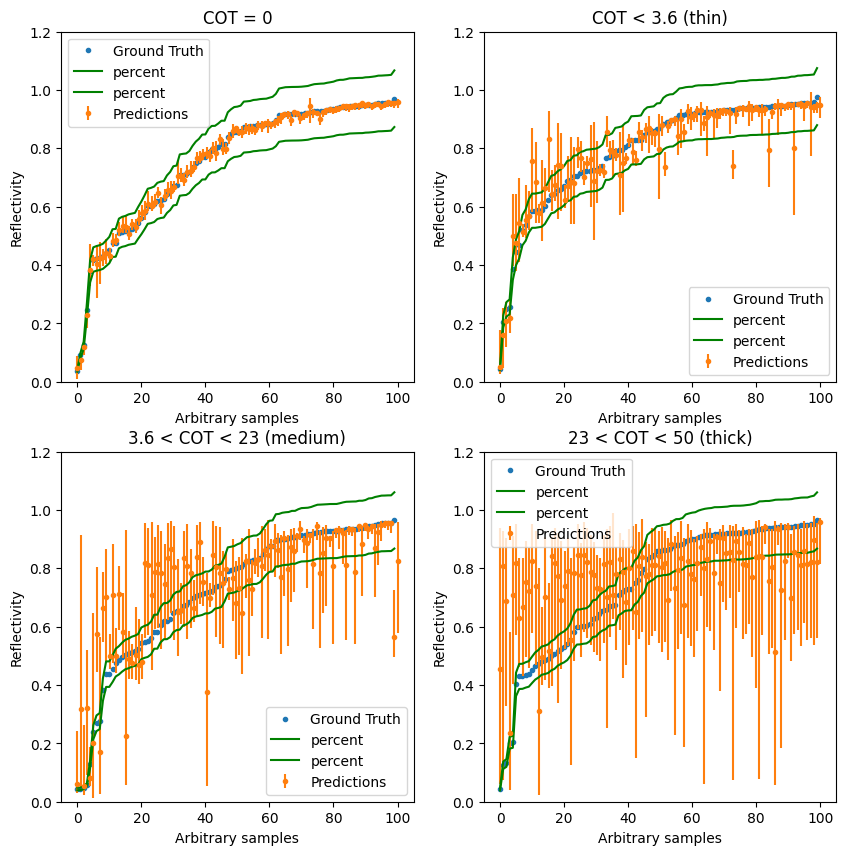

In [42]:

plt.rcParams["figure.figsize"] = [10, 10]
fig, axs=plt.subplots(ncols=2,nrows=2)
samples=100
index_median=4
#sort=np.argsort(y_true)
#y_true_sort=y_true[sort]
#y_pred_sort=pred_y[sort]
y_true_11=y_true[:,10]
pred_y_11=pred_y[:,10,:]

y_true_11_zero=y_true_11[indices_zero]
y_true_11_thin=y_true_11[indices_thin]
y_true_11_med=y_true_11[indices_med]
y_true_11_thick=y_true_11[indices_thick]

pred_y_11_zero=pred_y_11[indices_zero]
pred_y_11_thin=pred_y_11[indices_thin]
pred_y_11_med=pred_y_11[indices_med]
pred_y_11_thick=pred_y_11[indices_thick]


## ZERO COT ##
y_samp=y_true_11_zero[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_zero[:samples][sort]
# Plot the values
axs[0,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[0,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[0,0].set_xlabel("Arbitrary samples")
axs[0,0].set_ylabel("Reflectivity")
axs[0,0].set_ylim((0,1.2))
axs[0,0].legend()
axs[0,0].set_title("COT = 0")



y_samp=y_true_11_thin[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thin[:samples][sort]
# Plot the values
axs[0,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[0,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[0,1].set_xlabel("Arbitrary samples")
axs[0,1].set_ylabel("Reflectivity")
axs[0,1].set_ylim((0,1.2))
axs[0,1].legend()
axs[0,1].set_title("COT < 3.6 (thin)")


y_samp=y_true_11_med[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_med[:samples][sort]
# Plot the values
axs[1,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[1,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[1,0].set_xlabel("Arbitrary samples")
axs[1,0].set_ylabel("Reflectivity")
axs[1,0].set_ylim((0,1.2))
axs[1,0].legend()
axs[1,0].set_title("3.6 < COT < 23 (medium)")


y_samp=y_true_11_thick[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thick[:samples][sort]
# Plot the values
axs[1,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[1,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[1,1].set_xlabel("Arbitrary samples")
axs[1,1].set_ylabel("Reflectivity")
axs[1,1].set_ylim((0,1.2))
axs[1,1].legend()
axs[1,1].set_title("23 < COT < 50 (thick)")

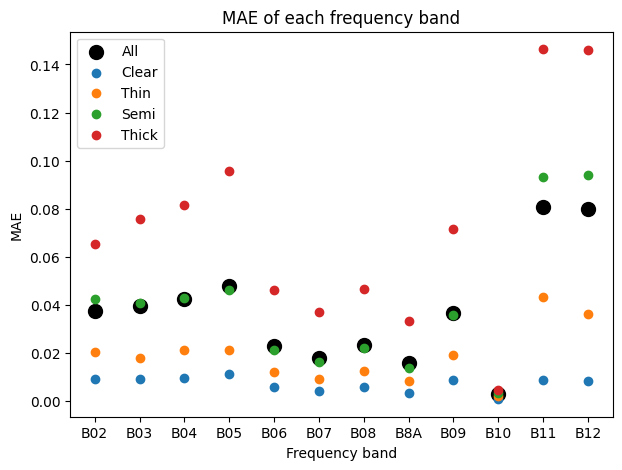

In [43]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = pred_y[(COTs==0),:,:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = pred_y[(COTs>0) & (COTs<3.6),:,:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = pred_y[(COTs>=3.6) & (COTs<23),:,:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = pred_y[(COTs>=23),:,:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-pred_y[:,:,index_median]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,index_median]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,index_median]),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred[:,:,index_median]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,index_median]),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.rcParams["figure.figsize"] = [7, 5]
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

In [44]:
np.shape(pred_y_11)

(20000, 9)

In [45]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

Text(0, 0.5, 'Ground Truth')

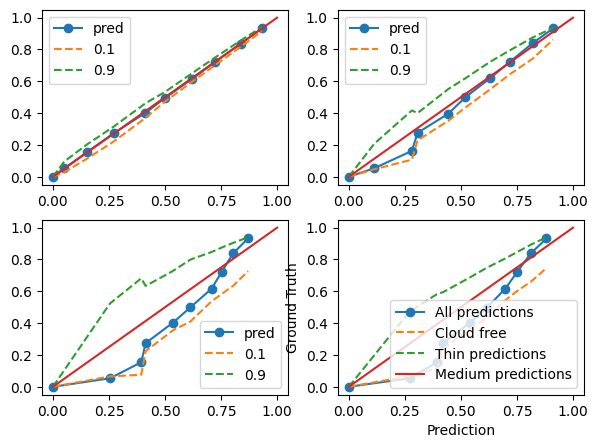

In [46]:


band=10
## Prediction v Ground Truth ##
y_true_11=y_test.to_numpy()[:,band]
pred_y_11=pred_y[:,band]
bins=np.linspace(0,1,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))
unc_1=np.zeros(len(bins))
unc_9=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))
unc_1_zero=np.zeros(len(bins))
unc_9_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))
unc_1_thin=np.zeros(len(bins))
unc_9_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))
unc_1_med=np.zeros(len(bins))
unc_9_med=np.zeros(len(bins))

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices,index_median])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z,index_median])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t,index_median])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m,index_median])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred
        unc_1[j]=np.mean(pred_y_11[indices,0])
        unc_9[j]=np.mean(pred_y_11[indices,-1])

        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero
        unc_1_zero[j]=np.mean(y_tmp_pred_zero[ind_z,0])
        unc_9_zero[j]=np.mean(y_tmp_pred_zero[ind_z,-1])

        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin
        unc_1_thin[j]=np.mean(y_tmp_pred_thin[ind_t,0])
        unc_9_thin[j]=np.mean(y_tmp_pred_thin[ind_t,-1])

        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med
        unc_1_med[j]=np.mean(y_tmp_pred_med[ind_m,0])
        unc_9_med[j]=np.mean(y_tmp_pred_med[ind_m,-1])



ncols=2
nrows=2
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]

axs[0,0].plot(freq_pred_zero,freq_true_zero,'-o')
axs[0,0].plot(freq_pred_zero,unc_1_zero,'--')
axs[0,0].plot(freq_pred_zero,unc_9_zero,'--')
axs[0,0].legend(['pred','0.1','0.9'])

axs[0,1].plot(freq_pred_thin,freq_true_thin,'-o')
axs[0,1].plot(freq_pred_thin,unc_1_thin,'--')
axs[0,1].plot(freq_pred_thin,unc_9_thin,'--')
axs[0,1].legend(['pred','0.1','0.9'])

axs[1,0].plot(freq_pred_med,freq_true_med,'-o')
axs[1,0].plot(freq_pred_med,unc_1_med,'--')
axs[1,0].plot(freq_pred_med,unc_9_med,'--')
axs[1,0].legend(['pred','0.1','0.9'])

axs[1,1].plot(freq_pred,freq_true,'-o')
axs[1,1].plot(freq_pred,unc_1,'--')
axs[1,1].plot(freq_pred,unc_9,'--')
axs[1,1].legend(['pred','0.1','0.9'])
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
axs[0,0].plot(line,line)
axs[0,1].plot(line,line)
axs[1,0].plot(line,line)
axs[1,1].plot(line,line)
plt.legend(['All predictions','Cloud free','Thin predictions','Medium predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")

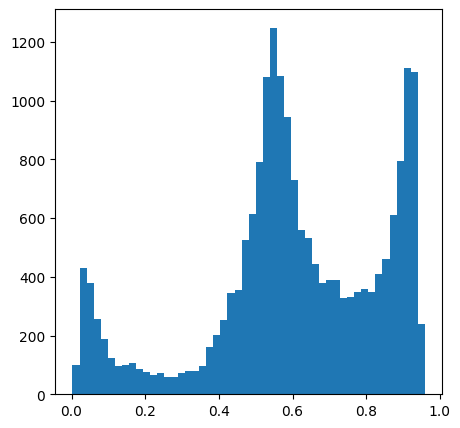

In [47]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(pred_y_11[:,0],bins=50)
plt.show()

In [48]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

In [49]:
#np.mean(pred_y_7[:,4])

In [50]:
#plt.hist(pred_y_7[:,4],alpha=0.7)
#plt.hist(y_test['Clear_B05'],alpha=0.7)

In [51]:
np.mean(pred_y_7,axis=0)

array([0.01060786, 0.01258953, 0.01353653, 0.01428172, 0.01517466,
       0.01613522, 0.01723055, 0.01883075, 0.02169778])

In [52]:
np.mean(y_test.to_numpy()[:,9])

0.0159948185

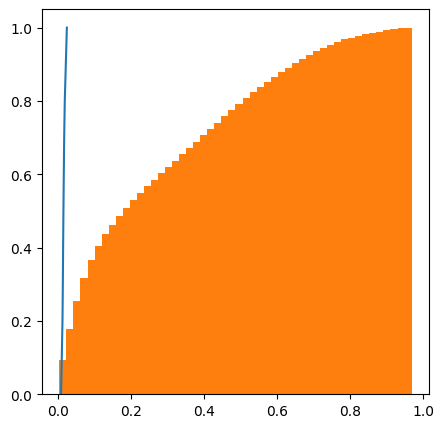

In [53]:
quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_y_7=pred_y[:,9,:]
x_cdf, y_cdf = cdf(pred_y_7,X_test.to_numpy(),quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test['Clear_B10'],cumulative=True, density=True,bins=50)
plt.show()


In [54]:
np.shape(x_cdf[(COTs<3.6) &(COTs>0) ,:])

(2197, 11)

In [55]:
np.shape(x_cdf)

(20000, 11)

In [56]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,index_median]))
R2.append(r2_score(y_true,pred_y[:,:,index_median]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,index_median]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [57]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.006481762998444031
 
R2 score: 0.8552458322746755
 
PSNR: 21.910429568311542
 
Quantrate: [0.08346667 0.16121667 0.25985    0.37006667 0.4831     0.60178333
 0.72095417 0.8266375  0.92439167]
 
Quantile crossing: 0.0


In [58]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [59]:

MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_true,pred_y[:,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_clear.index],pred_y[df_test_clear.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thin.index],pred_y[df_test_thin.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_med.index],pred_y[df_test_med.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thick.index],pred_y[df_test_thick.index,:,4]))

In [60]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.006481762998444031
MSE clear test data: 0.0001404133296943806
MSE thin COT <3.6 test data: 0.0016329362963051267
MSE med COT <23 test data: 0.0057498158537179
MSE thick COT <50 test data: 0.015593127713414113


## Cloud spectrum comparison

In [61]:
data_water_CO=parse.parse('cloudrm_water_black_surf.dat')
data_clear_CO=parse.parse('cloudrm_clear_black_surf.dat')
data_ice_CO=parse.parse('cloudrm_ice_black_surf.dat')
data_mixed_CO=parse.parse('cloudrm_mixed_black_surf.dat')

data_CO=pd.concat([data_water_CO,data_clear_CO,data_ice_CO,data_mixed_CO])
data_CO_X=data_CO[X_labels]

In [62]:
estimated_cloud=X_test.to_numpy()-pred_y[:,:,index_median]
true_cloud=data_CO_X.to_numpy()

ValueError: operands could not be broadcast together with shapes (20000,13) (20000,12) 

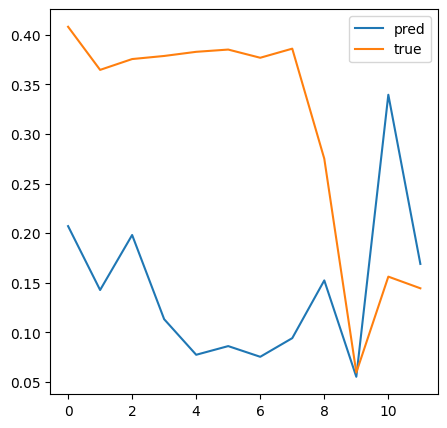

In [ ]:
plt.plot(np.mean(np.abs(estimated_cloud),axis=0))
plt.plot(np.mean(np.abs(true_cloud),axis=0))
plt.legend(['pred','true'])